In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pygame
import sys
from PIL import Image
from IPython import display as ipythonDisplay
#해당 그래프를 인라인으로 표시
#%matplotlib inline

In [2]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
observation = env.reset()
print(observation)

(array([-0.04168531, -0.01275495, -0.03367684,  0.0196571 ], dtype=float32), {})


In [65]:
for _ in range(100):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, trunk, info = env.step(action)
    print(action, observation, reward, done, trunk)
env.close()

1 [ 0.00382532  0.14734685  0.01510661 -0.25669605] 1.0 False False
0 [ 0.00677225 -0.04798749  0.00997268  0.0407132 ] 1.0 False False
0 [ 0.0058125  -0.24325101  0.01078695  0.33652586] 1.0 False False
1 [ 0.00094748 -0.04828422  0.01751747  0.04726397] 1.0 False False
1 [-1.8200519e-05  1.4658222e-01  1.8462745e-02 -2.3984097e-01] 1.0 False False
0 [ 0.00291344 -0.04879855  0.01366593  0.05860797] 1.0 False False
0 [ 0.00193747 -0.24411374  0.01483808  0.35557106] 1.0 False False
1 [-0.0029448  -0.04920588  0.02194951  0.06760368] 1.0 False False
0 [-0.00392892 -0.24463552  0.02330158  0.3671302 ] 1.0 False False
1 [-0.00882163 -0.04985231  0.03064418  0.08188471] 1.0 False False
1 [-0.00981868  0.14481726  0.03228188 -0.20097457] 1.0 False False
1 [-0.00692233  0.339463    0.02826239 -0.48330182] 1.0 False False
1 [-1.3307098e-04  5.3417492e-01  1.8596349e-02 -7.6694500e-01] 1.0 False False
1 [ 0.01055043  0.729036    0.00325745 -1.053719  ] 1.0 False False
0 [ 0.02513115  0.533871

c:\Users\CHR\anaconda3\Lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [66]:
for i_episode in range(2):
    observation = env.reset()
    for k in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, trunk, info = env.step(action)
        if done :
            print("Episode finished after {} timesteps".format(k+1))
            break

env.close()

Episode finished after 10 timesteps
Episode finished after 50 timesteps


In [3]:
n_bins_pos = 10
n_bins_vel = 10
n_bins_ang = 10
n_bins_anv = 10
# 연속적인 상태를 discrete하게 변환해주는 함수
def map_discrete_state(state):
    pos, vel, ang, anv = state
    
    idx_pos = np.where(np.histogram(np.clip(pos,-2,2), bins = n_bins_pos, range = (-2,2))[0] == 1)[0][0]
    idx_vel = np.where(np.histogram(np.clip(vel,-2,2), bins = n_bins_vel, range = (-2,2))[0] == 1)[0][0]
    idx_ang = np.where(np.histogram(np.clip(ang,-0.4,0.4), bins = n_bins_ang, range = (-0.4,0.4))[0] == 1)[0][0]
    idx_anv = np.where(np.histogram(np.clip(anv,-2,2), bins = n_bins_anv, range = (-2,2))[0] == 1)[0][0]

    states = np.zeros([n_bins_pos, n_bins_vel, n_bins_ang, n_bins_anv])
    states[idx_pos, idx_vel, idx_ang, idx_anv] = 1

    states = states.reshape(-1,1)

    s = np.where(states == 1)[0][0]
    
    return s  



Episode: 0 steps: 28
Episode: 100 steps: 26
Episode: 200 steps: 125
Episode: 300 steps: 67
Episode: 400 steps: 109
Episode: 500 steps: 85
Episode: 600 steps: 100
Episode: 700 steps: 347
Episode: 800 steps: 180


<StemContainer object of 3 artists>

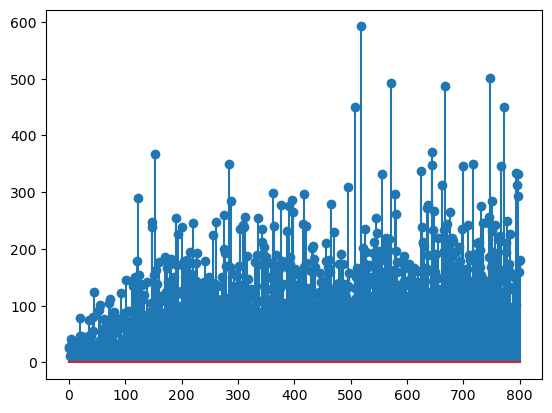

In [5]:
alpha = 0.3
gamma = 0.9
n_states = n_bins_pos*n_bins_vel*n_bins_ang*n_bins_anv
n_actions = 2
trial = []
Q_table = np.random.uniform(0, 1, (n_states, n_actions))

for episode in range(801):
    
    done = False
    state, _ = env.reset()
    
    count = 0
    
    while not done:
        
        count += 1
        
        s = map_discrete_state(state)    

        # Exploration vs. Exploitation for action       
        epsilon = 0.1
        if np.random.uniform() < epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_table[s, :])                

        # next state and reward
        next_state, reward, done, _, _ = env.step(a) 
                
        if done:        
            reward = -100        
            Q_table[s, a] = reward
                 
        else:                                               
            # Temporal Difference Update
            next_s = map_discrete_state(next_state)
            Q_table[s, a] = (1 - alpha)*Q_table[s, a] + alpha*(reward + gamma*np.max(Q_table[next_s, :]))

        state = next_state
    trial.append(count)
    if episode % 100 == 0:
        print("Episode: {} steps: {}".format(episode, count))
        
env.close()
plt.stem(trial)

In [72]:

state, _ = env.reset()

done = False
cnt = 0
screen = env.render()
images = [Image.fromarray(screen)]
while not done:
   
    if cnt % 10 == 0:
        screen = env.render()
        images.append(Image.fromarray(screen))
    s = map_discrete_state(state)
    a = np.argmax(Q_table[s,:])
    
    next_state, _, done, _, _ = env.step(a)      
    state = next_state  
    cnt +=1  
env.close()

image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)